In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tqdm as tqdm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D,MaxPooling2D, Dropout, Flatten, Activation, Input, Add
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report


import random
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #turn TF warnings

#offline usage of plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from IPython.display import clear_output
clear_output()


In [2]:
tf.random.set_seed(100)
np.random.seed(100)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
#load datasets paths
path = '/kaggle/input/cxr-for-cptn/Dataset'
path2 = '/kaggle/input/more-healthy-cxr'

In [4]:
#1. The path with 4 different datasets
images = []
labels = []

for label in os.listdir(path):
    label_dir = os.path.join(path, label)
    for img in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img)
        images.append(img_path)
        labels.append(label)
    images, labels = shuffle(images,labels)

In [5]:
#2. The path with Normal instances alone
for labl in os.listdir(path2):
    labl_path = os.path.join(path2, labl)
    for imgs in os.listdir(labl_path):
        imgs_path = os.path.join(labl_path,imgs)
        images.append(imgs_path)
        labels.append(labl)
    images, labels = shuffle(images, labels)
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'images':images, 'labels':labels})
df.head()

,images,labels
0,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person1547_virus_2688.jpeg,PNEUMONIA
1,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/IM-0033-0001-0001.jpeg,NORMAL
2,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person645_bacteria_2537.jpeg,PNEUMONIA
3,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person4_bacteria_14.jpeg,PNEUMONIA
4,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person1449_virus_2474.jpeg,PNEUMONIA


In [6]:
len(df)

13188

In [7]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets with stratified sampling
train_val, test_df = train_test_split(df, test_size=0.1, stratify=df['labels'], random_state=42)
# Split the train set into train and validation sets with stratified sampling
train_df, val_df = train_test_split(train_val, test_size=0.1, stratify=train_val['labels'], random_state=42)

In [8]:
print("Original train+val set:", train_val.shape)
print("Train set:",train_df.shape)
print("Test set:",test_df.shape)
print("Val set:",val_df.shape)

Original train+val set: (11869, 2)
Train set: (10682, 2)
Test set: (1319, 2)
Val set: (1187, 2)


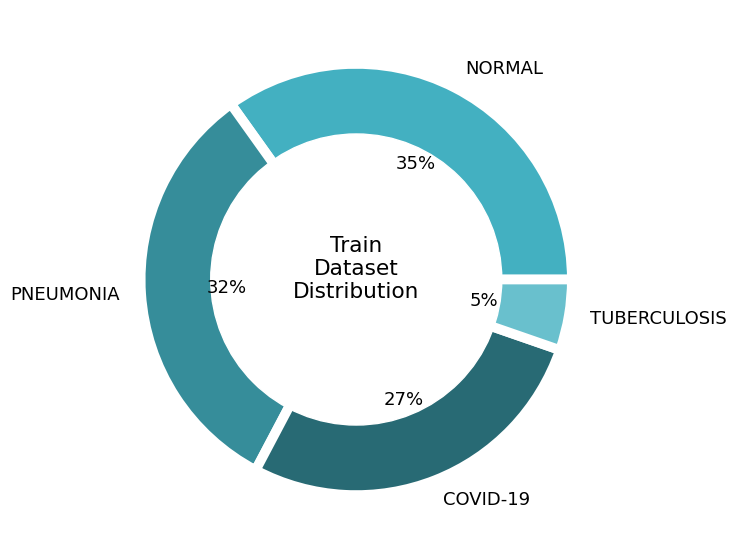

In [9]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(7,7))
# plotting data on chart
plt.pie(list(df.labels.value_counts()),
        labels=list(train_df.labels.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Train\nDataset\nDistribution', x=0.5, y=0.45) 
plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class configurations:
    IMAGE_SIZE = 299
    BRIGHTNESS = (0.64, 1.37) # (MIN, MAX)
    CONTRAST = (0.64, 1.37) # (MIX, MAX)
    BATCH_SIZE = 32
    EPOCHS = 10
    LEARNING_RATE = 0.001
def augment_image(image):
    datagen = ImageDataGenerator(
        brightness_range=configurations.BRIGHTNESS,
        rescale = 1./255
        
    )
    # Convert input image from numpy to PIL Image
    image = np.expand_dims(image, axis=0)
    # Apply Transformations
    image = datagen.flow(image, batch_size=1)[0][0]
    return image

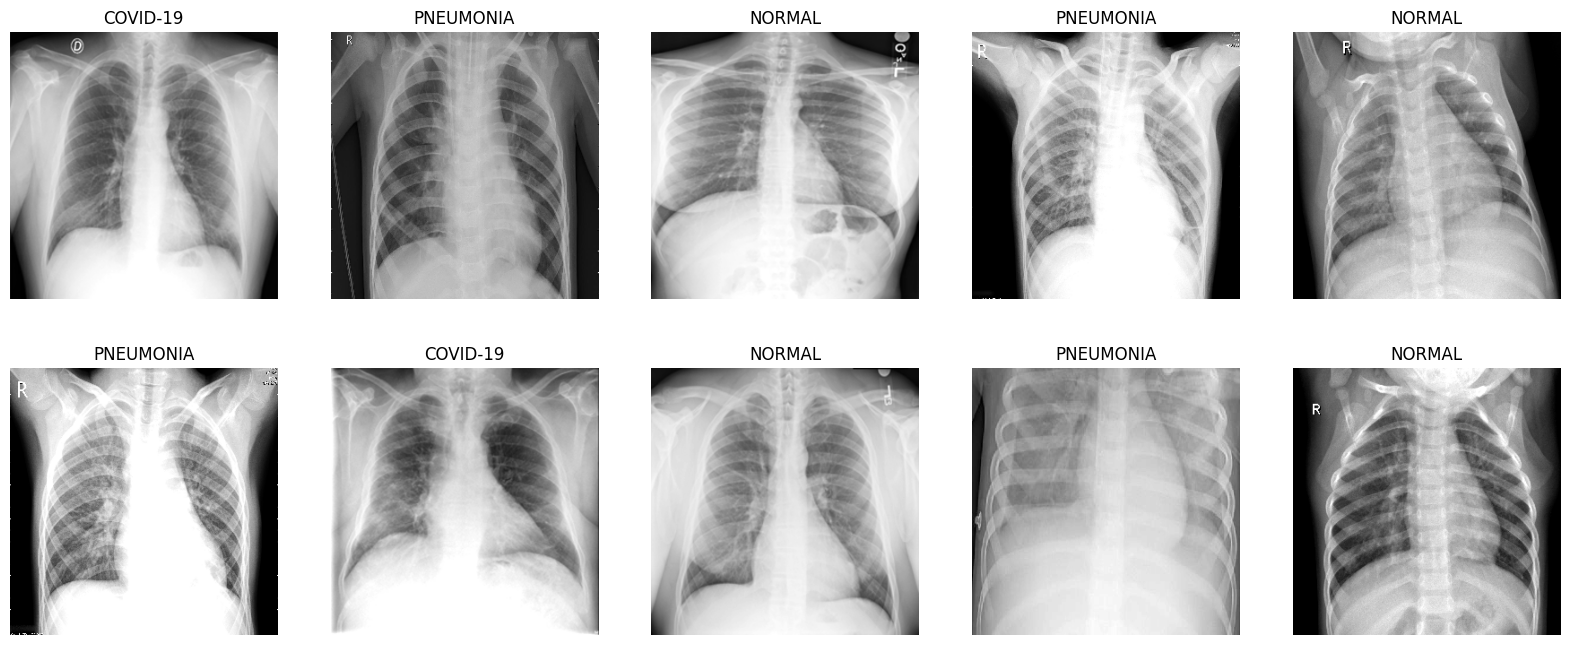

In [11]:
from tensorflow.keras.preprocessing.image import load_img
def open_images(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(configurations.IMAGE_SIZE,configurations.IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)
        image = image/image.max()
        images.append(image)
    return np.array(images)

# Randomly select and plot a few images with augmentation
k = random.randint(0,5000)
image_paths = list(train_df.images[k:k+10])
labels = list(train_df.labels[k:k+10])
images = open_images(image_paths, augment=True)
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))

for i in range(0, 10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

In [12]:
LABELS = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID-19']
label_encoder = {'NORMAL': 0, 'TUBERCULOSIS': 1, 'PNEUMONIA': 2, 'COVID-19': 3}
label_decoder = {0: 'NORMAL', 1: 'TUBERCULOSIS', 2: 'PNEUMONIA', 3: 'COVID-19'}

In [13]:
def data_generator(df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.images[x:x+batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.labels[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [14]:
# Creating generators for training and validation. You can change the parameters in the configuration section.
train_data_generator = data_generator(train_df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS)
train_steps = int(len(train_df)/configurations.BATCH_SIZE)

val_data_generator = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=configurations.EPOCHS)
val_steps = int(len(val_df)/configurations.BATCH_SIZE)

In [15]:
resnet_model= ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(299,299,3)))
for layer in resnet_model.layers[:-10]:
    layers.trainable=False
hm = resnet_model.output
hm = AveragePooling2D(pool_size=(4,4))(hm)
hm = Flatten(name = 'flatten')(hm)
hm = Dense(256, activation = 'relu')(hm)
hm = Dropout(0.3)(hm)
hm = Dense(128, activation = 'relu')(hm)
hm = Dropout(0.2)(hm)
hm = Dense(4,activation = 'softmax')(hm)

model = Model(inputs=resnet_model.input, outputs = hm)

In [16]:
from tensorflow.keras.optimizers import SGD
sgd_optimizer = SGD(configurations.LEARNING_RATE)
model.compile(optimizer=sgd_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [17]:
class_weights = (train_df.labels.value_counts() / len(train_df)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights

{0: 0.3487174686388317,
 2: 0.32400299569369034,
 3: 0.2741995880921176,
 1: 0.05307994757536042}

In [18]:
model_checkpoint_callback_imb = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/model_imb.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

history = model.fit(train_data_generator, epochs=configurations.EPOCHS, steps_per_epoch=train_steps,
          validation_data=val_data_generator, validation_steps=val_steps,class_weight = class_weights, callbacks=[model_checkpoint_callback_imb])

Epoch 1/10
333/333 [==============================] - ETA: 0s - loss: 0.2468 - accuracy: 0.6400
Epoch 1: val_accuracy improved from -inf to 0.27449, saving model to /kaggle/working/model_imb.hdf5
333/333 [==============================] - 169s 439ms/step - loss: 0.2468 - accuracy: 0.6400 - val_loss: 1.8302 - val_accuracy: 0.2745
Epoch 2/10
333/333 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.8168
Epoch 2: val_accuracy improved from 0.27449 to 0.32264, saving model to /kaggle/working/model_imb.hdf5
333/333 [==============================] - 138s 404ms/step - loss: 0.1228 - accuracy: 0.8168 - val_loss: 1.4659 - val_accuracy: 0.3226
Epoch 3/10
333/333 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.8529
Epoch 3: val_accuracy improved from 0.32264 to 0.79645, saving model to /kaggle/working/model_imb.hdf5
333/333 [==============================] - 138s 413ms/step - loss: 0.0926 - accuracy: 0.8529 - val_loss: 0.5784 - val_accuracy: 0.7965
E

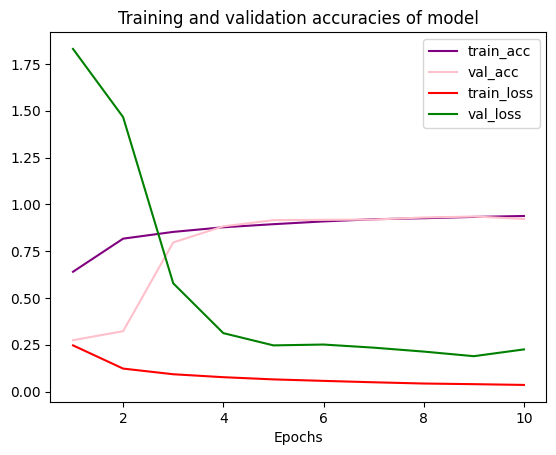

In [19]:
epochs = range (1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], color = 'purple')
plt.plot(epochs, history.history['val_accuracy'], color = 'pink')
plt.plot(epochs, history.history['loss'], color = 'red')
plt.plot(epochs, history.history['val_loss'], color = 'green')
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training and validation accuracies of model')
plt.legend(["train_acc","val_acc","train_loss","val_loss"], loc = "upper right")
plt.show()